In [237]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [238]:
def flatten(list_name):
    """ 
    Function that flattens list of lists.

    Parameters
    ----------
    list_name: str
        Name of the list to flatten
    
    Returns
    -------
    Flattened list
    """
    flattened = [item for sublist in list_name for item in sublist]
    return flattened

# some data points are invalid, ie they are <-1 or >1. This is usually because the Tobii has lost track of one or both eyes and the data points around the edges are odd.
# We will just set these values to the max value that is considered on screen (1/-1).
def set_to_min_max(gaze_df, gaze_dat_col, upper_bound, lower_bound):
    """
    Set eye tracking data to min/max value
    where gaze point data have been recorded
    as being off the screen (>1, <-1)

    Parameters
    ----------
    gaze_df:    pd DataFrame
        dataframe containing gaze point data
    gaze_dat_col:   list[str]
        name(s) of columns to be checked
        eg [gaze_in_x, gaze_in_y]
    upper_bound:    int
        value indicating max on screen coordinate
    lower_bound:    int
        value indicating min on screen coordinate
    
    Returns
    -------
    gaze_df with values capped at upper_bound/lower_bound
    """
    for col in gaze_dat_col:
        et_df.loc[:,col] = et_df[col].where(et_df[col].between(lower_bound,upper_bound),np.nan)
        num_inval_rows_after = et_df.shape[0]-et_df[et_df[col].between(lower_bound,upper_bound)].shape[0]
    return gaze_df

def remove_duplicates_patch(in_list):
    """
    patch to remove duplicates from
    list of lists.
    Uses set.

    Parameters
    ----------
    in_list:    list[list]
        list of lists with duplicate lists
    
    Returns
    -------
    list of lists w/o duplicates.
    """
    new_list = [
                list(mytuple)
                for mytuple in set(tuple(val) 
                for val in in_list)
                ]
    return new_list

class ODetect:
    """Trying out different ways of 
        detecting outliers in the gaze data"""

    def __init__(self, method_name,gaze_col_names):
        self.method_name = method_name
        self.gaze_cols = gaze_col_names
    
    def use_lof(self,nneigh, contam, X):
        """
        Outlier detection using LOF.
        
        Parameters
        ----------
        nneigh: int
            number of nearest neighbours
        contam: float or "auto"
            contamination
        X:  pd DataFrame
            input dataframe containing
            gaze data in x and y
        """
        clf = LocalOutlierFactor(n_neighbors = nneigh, contamination = contam)
        self.y_pred_lof = clf.fit_predict(X.loc[:,self.gaze_cols])
        self.X_scores_lof = clf.negative_outlier_factor_
        
    
    def use_dbscan(self,epsilon,min_points,X):
        """
        Use dbscan for outlier detection.

        Parameters
        ----------
        epsilon,min_points:    float,int
            dbscan parameters controlling
            density and minimum number of points
            in cluster
        X:  pd DataFrame
            input dataframe containing
            gaze data in x and y
        """
        dbscan = DBSCAN(eps = epsilon,min_samples = min_points).fit(X.loc[:,self.gaze_cols])
        self.y_pred_dbscan = dbscan.labels_
        
def show_crossval_results(scores):
    """
    Display cross validation scores.

    Parameters
    ----------
    scores  array
        cross validation scores
    """
    print("Scores:",scores)
    print("Mean:", round(scores.mean(),2))
    print("Std:", round(scores.std(),2))

Read in the tobii files for all available participants. Remember to specify the correct file path and adjust the substrings filtered for in the list comprehensions, if needed.
As new participants will be added over time, one thing that's worth thinking about is to just run this script on the new participants. Since the files are pretty large, you my not want to reprocess data from participants whose data have already been processed to get the new features we wanted to use in the analysis later on.

In [239]:
home = 0
if home:
    rawfilepath = r"C:\Users\Luzia T\Eye-gaze-divergence"
    Tobii_files = [f for f in os.listdir(rawfilepath) if 'merged' in f]
    calibration_files = [f for f in os.listdir(rawfilepath) if 'calib' in f]
else:
    # first we need to establish where to find the files and read them in.
    rawfilepath = r"P:\Spironolactone\Tobii"
    #rawfilepath = r"P:\Spironolactone\eye_tracking\Tobii"
    intrusions_dir = r"P:\Eye-gaze-divergence"
    # get merged Tobii files - these have both event info and eye gaze data.
    Tobii_files = [f for f in os.listdir(rawfilepath) if 'merged' in f]
    # get_calibration files
    calibration_files = [f for f in os.listdir(rawfilepath) if 'calib' in f and f.endswith('.tsv')]
    msg_files = [f for f in os.listdir(rawfilepath) if 'msg' in f and f.endswith('.tsv')]

In [240]:
# get pnum, left/right gaze point on display area, event messages 
# keep only columns between framenum 0 and the last frame
# set invalid samples to NaN (validity == 0)
frames = []
gaze_in_x = []
gaze_in_y = []
pnums = []
# threshold for missing data. If more than missing_thresh gaze point data missing,
# do not use record for this participant.
missing_thresh = 0.3

print("Now processing tobii files....")
for i,filename in enumerate(Tobii_files):
    # read file
    tobii_file = pd.read_table(os.path.join(rawfilepath, filename))
    # get participant number and add as column
    tobii_file['pnum'] = np.repeat([int(s) for s in filename.split('_') if s.isdigit()], tobii_file.shape[0])
    # get row index of frame each frame presentation
    event_index = tobii_file.loc[tobii_file.msg.str.contains('FRAME',na = False),'msg'].index
    # drop everything before first frame index (ie frame 0) and after last frame
    tobii_file = tobii_file.loc[event_index[0]:event_index[-1],:]
    # extract frame number from event time stamps
    tobii_file.loc[event_index, 'msg'] = [f[0] for f in tobii_file.loc[event_index,'msg'].str.split(';', n = 1)]
    tobii_file['frame_num'] = tobii_file.loc[event_index,'msg'].apply(lambda x: re.findall(r'\d',x)).apply(''.join).astype('int')
    # fill the rows between event markers with the appropriate frame number
    tobii_file.loc[:,'frame_num'] = tobii_file.loc[:,'frame_num'].fillna(method = 'ffill')
    # drop event markers
    tobii_file = tobii_file.drop(labels = event_index,axis = 0)
    tobii_file = tobii_file.groupby('frame_num').mean()
    tobii_file = tobii_file.reset_index()
    # check if participant has excessive missing data
    if tobii_file["left_gaze_point_on_display_area_x"].isna().sum()/tobii_file.shape[0]>missing_thresh:
        print(f"Participant {tobii_file.pnum.unique()} has >30% missing data. Omitting.")
    # collect data into lists
    pnums.append(tobii_file.pnum.values)
    gaze_in_x.append(tobii_file.left_gaze_point_on_display_area_x.values)
    gaze_in_y.append(tobii_file.left_gaze_point_on_display_area_y.values)
    frames.append(tobii_file.frame_num.values)
    print(f"{round(((i+1)/len(Tobii_files))*100,2)}% done.", end = "\r")
    
# create dataframe
et_df = pd.DataFrame({'id':flatten(pnums),'gaze_in_x':flatten(gaze_in_x),'gaze_in_y':flatten(gaze_in_y),'frame_num':flatten(frames)})

Now processing tobii files....
Participant [13] has >30% missing data. Omitting.
Participant [18] has >30% missing data. Omitting.
Participant [26] has >30% missing data. Omitting.
Participant [28] has >30% missing data. Omitting.
Participant [34] has >30% missing data. Omitting.
Participant [35] has >30% missing data. Omitting.
Participant [39] has >30% missing data. Omitting.
Participant [45] has >30% missing data. Omitting.
Participant [46] has >30% missing data. Omitting.


Here, I didn't restrict the rows to only those with a "1" validity rating. The reason for this was that I wanted to retain all frames for all participants, as I would have had to manually insert nans later on due to the approach I chose. You can of course go back to filtering out invalid rows, but here I included them. When doing this, one thing that's important to remember is to set both x and y coordinates to nan, even if only x or y is nan. This sometimes happens when the eye tracker is just about to lose track of the eyes/when it is just about to find them again, but the data are typically not trustworthy and it's best to exclude.

In [241]:
# if gaze in x is nan, set gaze in y nan & vice versa.
et_df.loc[(et_df.gaze_in_x.isnull())|(et_df.gaze_in_y.isnull()),["gaze_in_x","gaze_in_y"]] = np.nan
# calculate % missing data (this will be for all participants and frames, *not* per participant)
perc_overall_missing = et_df[et_df.gaze_in_x.isnull()].shape[0]/et_df.shape[0]
print(f"Across frames and participants, {round(perc_overall_missing*100,2)}% gaze point data are missing.")

Across frames and participants, 20.17% gaze point data are missing.


Another thing that happens is that data may exceed the maximum or minimum screen value (1,-1). This also typically happens when the eye tracker has lost one or both eyes. For these values, we will set them to the min/max. Later on, I will also set nan vals to -1. I did this because I thought in this case it was the best approach to deal with missing values. For shorter sections (that likely correspond to blinks), some form of imputation may be appropriate. However, overall we want to know when people likely weren't looking at the screen, or at least not where most other people were looking at that time. As -1,-1 would be an extreme score unlikely to be classed as not outlying, this should work pretty well in detecting off-screen gaze/closed eyes. A note on blinking: Since everyone blinks (albeit at different times) and we are later going to use the number of 'outlying' gaze points across frames of the video, blinks are unlikely to sway the results of a classifier or regression model. 

In [242]:
# remove data points that are <-1 or >1 (this would correspond to gaze data that is off screen)
# usually this happens shortly before/after the eye tracker loses track of the eyes
et_df = set_to_min_max(et_df, ["gaze_in_x","gaze_in_y"],1,-1)

Let's calculate the median gaze path across the individual video frames. Assuming that the vast majority of participants will have looked at roughly the same areas of the screen throughout, this will help us in getting an idea of the 'typical' gaze path within our sample. Note that some changes in gaze position are expected as the action shifts from one place to another.

In [243]:
# calculate median per frame for x and y gaze positions.
median_et_df = et_df.loc[:,["frame_num","gaze_in_x","gaze_in_y"]].groupby("frame_num").median().reset_index()
# get the rolling average - this just smoothes things out a bit.
median_et_df["rolling_x"]= median_et_df.loc[:,["gaze_in_x"]].rolling(90).mean()
median_et_df["rolling_y"] = median_et_df.loc[:,["gaze_in_y"]].rolling(90).mean()

In [244]:
# plot
fig = px.line(median_et_df, x = "frame_num", y = ["gaze_in_x","gaze_in_y","rolling_x","rolling_y"], template = "plotly_dark")
fig.show()

Now we'll replace nans with -1s. See above for reasoning.

In [245]:
et_df = et_df.replace(np.nan, -1)
# check that no nans remain
print(f"Number of NaNs in each column after processing:\n{et_df.isna().sum()}")

Number of NaNs in each column after processing:
id           0
gaze_in_x    0
gaze_in_y    0
frame_num    0
dtype: int64


We are now going to identify outlying gaze data for each frame. Here, I'm using local outlier factor to do this. I have also tried DBSCAN (a clustering method), but had concerns that epsilon would need tuning, but was unsure just how much and how often so would have had to write separate functions to do that, adding complexity.
I played around with it a little bit and LOF seemed to work "better" overall.
As an output, we get the negative outlier factor and we also get labels (-1 for outlier). This is what we're going to be using later on to create our feature.

In [246]:
ofscores = []
pnums = []
ypreds = []
frame_nums = []
#od = ODetect("dbscan", ["gaze_in_x","gaze_in_y"])
od = ODetect("lof", ["gaze_in_x","gaze_in_y"])

for frame in et_df.frame_num[500:].unique():
    X = et_df.loc[et_df.frame_num == frame,:]
    od.use_lof(15,"auto",X)
    #y_pred = od.y_pred_dbscan#dbscan.labels_
    y_pred = od.y_pred_lof
    X_scores = od.X_scores_lof
    frames = np.tile(frame, len(y_pred))
    frame_nums.append(frames)
    ypreds.append(y_pred)
    ofscores.append(X_scores)
    pnums.append(X.id)

Put everything into a dataframe.

In [247]:
my_dict = {
            "frame_num": [vals for sublist in frame_nums for vals in sublist], # can use np.ravel here as well
            "id":[vals for sublist in pnums for vals in sublist],
            #"ofscores":[vals for sublist in ofscores for vals in sublist],
            "labels":[vals for sublist in ypreds for vals in sublist]
            }
scores_labels_df = pd.DataFrame(data = my_dict)

We now want to use the information about outlier status in our remaining analysis. One question we might ask is whether the number of frames during which a participant's gaze data was labelled as an outlier is linked to the number of/vividness and/or distress associated with intrusions. As such, we can generate a new feature that gives us the number of 'outlier' labels for each participant across all frames of the video.

In [248]:
# get the number of outlier labels for each participant
num_of_labels_df = scores_labels_df[
                                    scores_labels_df.labels == -1
                                    ].groupby("id")["labels"].sum()
# take the absolute value
num_of_labels_df = num_of_labels_df.abs()
print(num_of_labels_df.describe())

count       45.000000
mean      7818.311111
std       7048.274363
min       1304.000000
25%       2379.000000
50%       4742.000000
75%      11492.000000
max      23437.000000
Name: labels, dtype: float64


In [249]:
px.histogram(num_of_labels_df.reset_index(), x = "labels",nbins = 30)

We can try visualizing the results for individual frames. Feel free to choose a few different frames and have a look at the points identified as outliers.

In [250]:
x2 = scores_labels_df[scores_labels_df.frame_num == 17657]
x2 = x2.join(et_df.loc[et_df.frame_num == 17657, ["id","gaze_in_x","gaze_in_y"]].set_index("id"),on = "id")
print(x2.head())

        frame_num  id  labels  gaze_in_x  gaze_in_y
772065    17657.0  10      -1   0.382238   0.583182
772066    17657.0  11       1   0.503463   0.631356
772067    17657.0  12       1   0.525586   0.548794
772068    17657.0  13      -1  -1.000000  -1.000000
772069    17657.0  14       1   0.495078   0.540273


In [251]:
fig = px.scatter(x2, x = "gaze_in_x", y = "gaze_in_y", color = "labels" ,template = "plotly_dark")
fig.show()

In [252]:
# read in survey and acute session intrusions data
acute_df = pd.read_csv(os.path.join(r"P:\Spironolactone","study_day_scores.csv"))

<ipython-input-253-07473198221c>:3: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



array([[<AxesSubplot:title={'center':'DQ-1'}>,
        <AxesSubplot:title={'center':'panas_t1_neg'}>,
        <AxesSubplot:title={'center':'panas_t1_pos'}>,
        <AxesSubplot:title={'center':'panas_t2_neg'}>,
        <AxesSubplot:title={'center':'panas_t2_pos'}>,
        <AxesSubplot:title={'center':'panas_t3_neg'}>,
        <AxesSubplot:title={'center':'panas_t3_pos'}>],
       [<AxesSubplot:title={'center':'stai_trait'}>,
        <AxesSubplot:title={'center':'erq_cra'}>,
        <AxesSubplot:title={'center':'erq_sup'}>,
        <AxesSubplot:title={'center':'memory_1'}>,
        <AxesSubplot:title={'center':'memory_2'}>,
        <AxesSubplot:title={'center':'memory_3'}>,
        <AxesSubplot:title={'center':'memory_4'}>],
       [<AxesSubplot:title={'center':'memory_5'}>,
        <AxesSubplot:title={'center':'memory_6'}>,
        <AxesSubplot:title={'center':'memory_7'}>,
        <AxesSubplot:title={'center':'memory_8'}>,
        <AxesSubplot:title={'center':'memory_9'}>,
        <

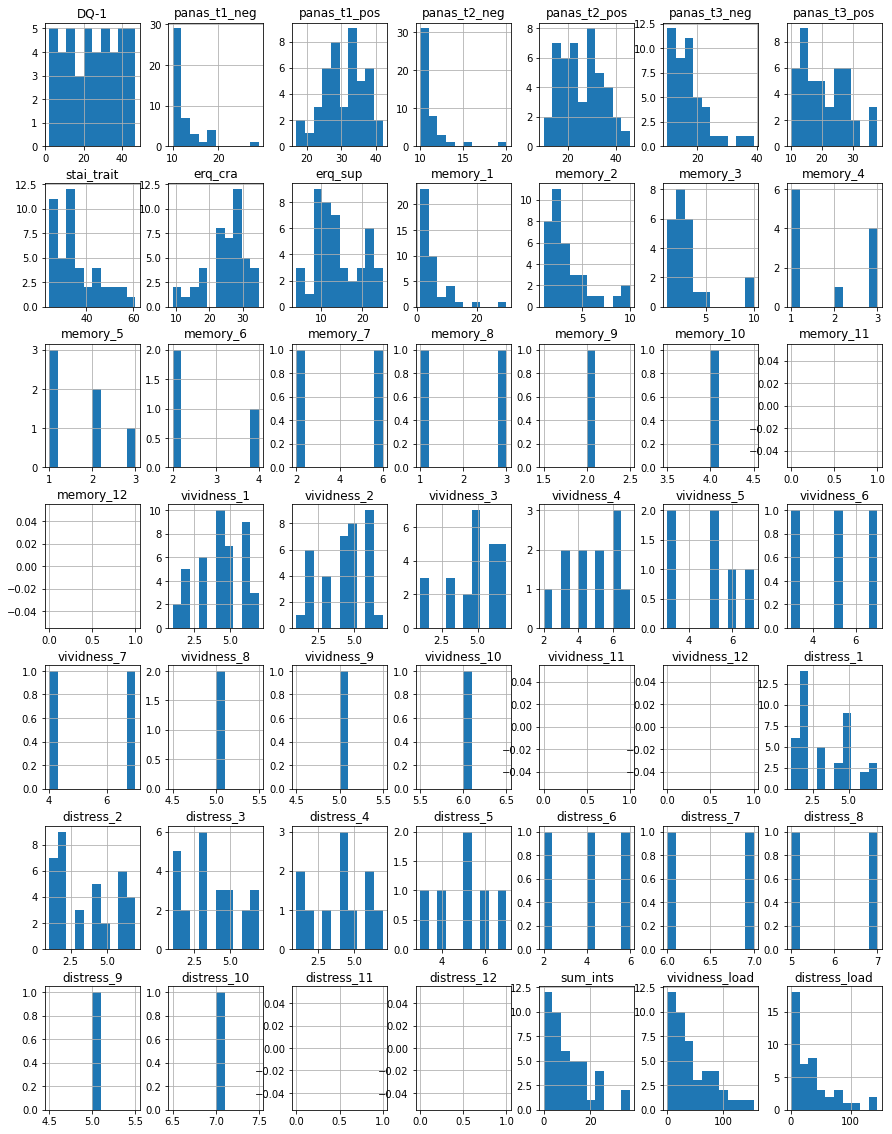

In [253]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
acute_df.hist(ax = ax)

In [254]:
acute_df = acute_df.rename({"DQ-1": "id"},axis = 1)
acute_df = acute_df.set_index("id")
acute_df["num_outlying_frames"] = num_of_labels_df

In [255]:
acute_df.head()

panas_t1_neg  panas_t1_pos  panas_t2_neg  panas_t2_pos  panas_t3_neg  \
id                                                                          
2.0            10            27            10            29            11   
3.0            10            21            10            14            12   
4.0            12            28            10            25            18   
5.0            10            37            10            27            17   
7.0            10            36            10            36            24   

     panas_t3_pos  stai_trait  erq_cra  erq_sup  memory_1  ...  distress_7  \
id                                                         ...               
2.0            20          33       27       17       3.0  ...         NaN   
3.0            11          26       34       22       4.0  ...         NaN   
4.0            24          50       28       25       NaN  ...         NaN   
5.0            15          32       29       19       1.0  ...         NaN   
7.0            25          26       31       12      20.0  ...         NaN   

     distress_8  distress_9  distress_10  distress_11  distress_12  sum_ints  \
id                                                                             
2.0         NaN         NaN          NaN          NaN          NaN       5.0   
3.0         NaN         NaN          NaN          NaN          NaN       4.0   
4.0         NaN         NaN          NaN          NaN          NaN       0.0   
5.0         NaN         NaN          NaN          NaN          NaN       1.0   
7.0         NaN         NaN          NaN          NaN          NaN      35.0   

     vividness_load  distress_load  num_outlying_frames  
id                                                       
2.0            28.0           15.0               4568.0  
3.0            16.0            8.0               2075.0  
4.0             0.0            0.0               4974.0  
5.0             5.0            7.0               3592.0  
7.0           154.0          145.0               8190.0  

[5 rows x 49 columns]

In [256]:
cols = ["panas_t2_pos","panas_t2_neg","panas_t3_pos", "panas_t3_neg"]
cols
for i,col in enumerate(cols):
    new_col = '_'.join(["diff",col])
    if "pos" in col:
        acute_df[new_col] = acute_df["panas_t1_pos"]-acute_df[col]
    elif "neg" in col:
        acute_df[new_col] = acute_df["panas_t1_neg"]-acute_df[col]
    else:
        "Column name not recognized."
        continue


In [257]:
acute_df["sum_distress"] = acute_df.filter(like = "distress",axis = 1).sum(axis = 1)
acute_df["sum_vividness"] = acute_df.filter(like = "vividness",axis = 1).sum(axis = 1)

In [258]:
retain_cols = ["stai_trait", "erq_cra","erq_sup","num_outlying_frames","diff_panas_t3_pos","diff_panas_t3_neg"]
X = acute_df.loc[:,retain_cols]
# Possible ys: "sum_ints","vividness_load","distress_load"

In [259]:

pre_et_pipeline = Pipeline([
                            ('imputer',  SimpleImputer(strategy = 'median')),
                            ('std_scaler', StandardScaler())
                            ])

X = pre_et_pipeline.fit_transform(X)
X_df = pd.DataFrame(X,index = acute_df.index, columns = retain_cols)

Correlation and pair plots for input features.

<AxesSubplot:>

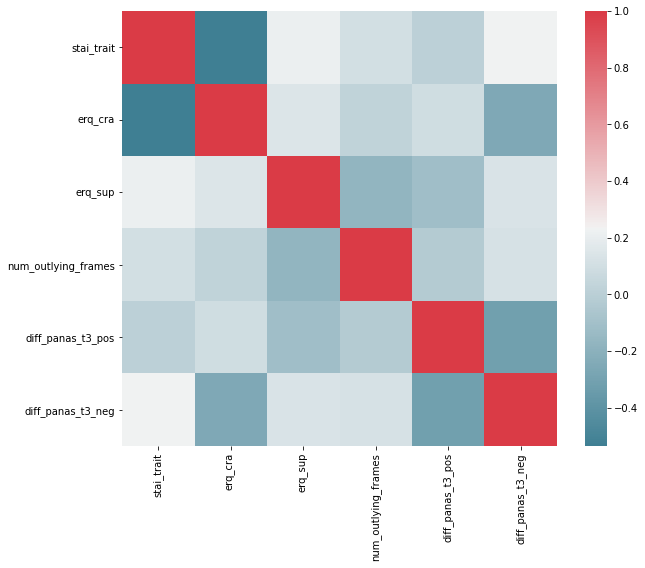

In [260]:
corr = X_df.corr(method = "spearman")

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

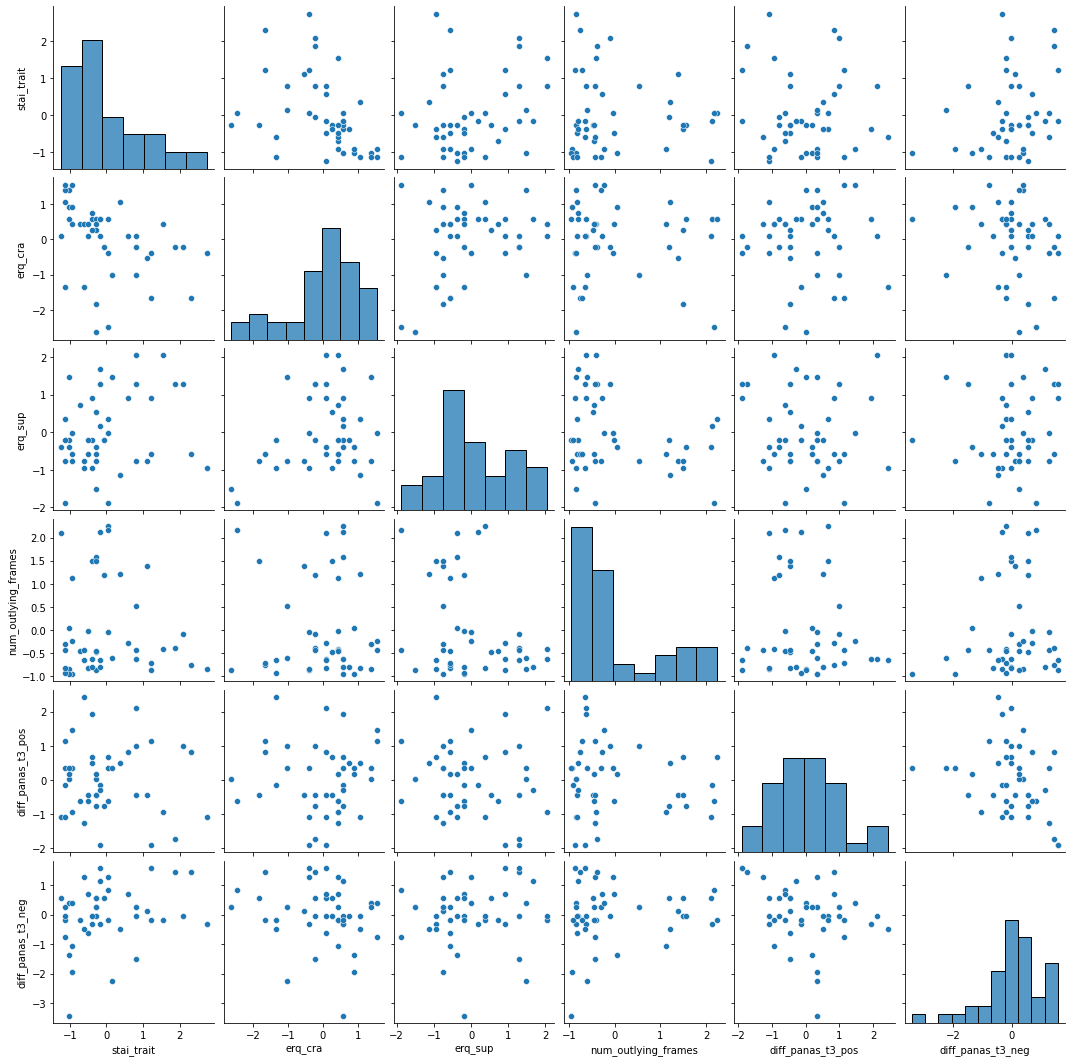

In [261]:
sns.pairplot(X_df)

Pair plots for number of actue intrusions, vividness and distress load.

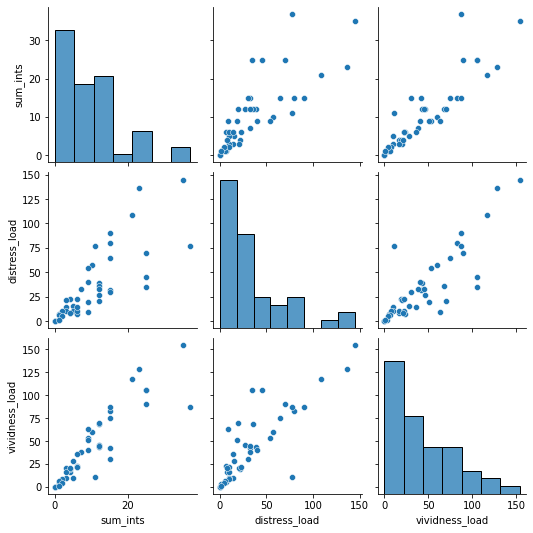

In [262]:
sns.pairplot(acute_df.loc[:,["sum_ints", "distress_load", "vividness_load"]])

In [263]:
acute_df.loc[:,["sum_ints", "distress_load", "vividness_load"]].corr(method = "spearman")

sum_ints  distress_load  vividness_load
sum_ints        1.000000       0.880671        0.934114
distress_load   0.880671       1.000000        0.844153
vividness_load  0.934114       0.844153        1.000000

In [264]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

y = acute_df.sum_ints
# replace missing eye tracking vals with median
X_train,X_test,y_train,y_test = train_test_split(X_df,y,test_size = 20, random_state = 42)
rndf = RandomForestRegressor(random_state = 42)#.fit(X_train,y_train)
rndf_scores = cross_val_score(rndf, X_train, y_train, #scoring = "neg_mean_squared_error",
                            cv = 5)
rndf_scores_sqrt = rndf_scores#np.sqrt(-rndf_scores)
show_crossval_results(rndf_scores_sqrt)
rndf_fitted = rndf.fit(X_train,y_train)
#y_pred = rndf_fitted.predict(X_test)
print("Test set score:",rndf_fitted.score(X_test,y_test))

Scores: [ 0.50360331 -0.99811786  0.2487997  -1.55687631 -1.43532218]
Mean: -0.65
Std: 0.86
Test set score: 0.031591736526946024


In [265]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor().fit(X_train,y_train)
y_pred_gbrt = gbrt.predict(X_test)
res_gbrt = y_pred_gbrt-y_test
gbrt.score(X_test,y_test)

0.04573609300810866

In [266]:
import xgboost

xgb = xgboost.XGBRegressor().fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
res_xgb = y_pred_xgb-y_test
xgb.score(X_test,y_test)

0.02753722385273205

Use LOF to identify subjects with "unusual" number of intrusions.
Labels will be used as output in classification.

In [267]:
ys_df = acute_df.loc[:,["sum_ints", "sum_distress", "sum_vividness"]]
lof_ys = LocalOutlierFactor(n_neighbors=10)
ys_df["labels"] = lof_ys.fit_predict(ys_df.loc[:,"sum_ints"].values.reshape(-1,1))
px.scatter(ys_df.reset_index(), x = "id", y = [ "sum_ints"], color = "labels" )

In [268]:
import functools
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [269]:
class TryClassifier:
    def __init__(self, Xtrain, ytrain, Xtest, classifier = RandomForestClassifier()):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.method = classifier
    
    def __call__(self,method_with_params = None):
        if method_with_params is None:
            clf = self.method
        else:
            clf = method_with_params            
        clf_f = clf.fit(self.Xtrain,self.ytrain)
        f_importance = clf_f.feature_importances_
        clf_pred = clf_f.predict(self.Xtest)
        clfcv_scores = cross_val_score(clf, self.Xtrain,
                        self.ytrain, cv = 5)
        return clf_pred, clfcv_scores,f_importance


In [270]:
yc = ys_df.labels
# replace missing eye tracking vals with median
X_train,X_test,y_train,y_test = train_test_split(X_df,yc,test_size = 20, random_state = 42)

Because of the low number of samples from the class of interest (high intrusions), the classifiers mostly predict the majority class. We'll  use imbalanced learn and SMOTE to boost the nubmer of minority class samples.

In [274]:
X_resamp,y_resamp = ADASYN().fit_resample(X_df,yc)
print(Counter(y_resamp).items())

dict_items([(1, 38), (-1, 37)])


In [275]:
clfs = [RandomForestClassifier(random_state = 42), AdaBoostClassifier(random_state = 42),
        GradientBoostingClassifier(random_state = 42)]
ypreds = []
cvscores = []
fimps = []
X_train,X_test,y_train,y_test = train_test_split(X_resamp,y_resamp,test_size = 20, random_state = 42)

for clf in clfs:
    test_classification = TryClassifier(X_train,y_train,X_test,classifier = clf)
    ypred,cvscore,fimportance= test_classification()
    ypreds.append(ypred)
    cvscores.append(cvscore)
    fimps.append(fimportance)

Check feature importance sccores for the above.

In [276]:
keys = [str(f)[:-17] for f in clfs]
vals = [val for val in fimps]
fimps_dict = dict(zip(keys,vals))
feature_importances_df = pd.DataFrame(data = fimps_dict,index = X_resamp.columns)
print(feature_importances_df)

                     RandomForestClassifier  AdaBoostClassifier  \
stai_trait                         0.101491                0.20   
erq_cra                            0.164958                0.16   
erq_sup                            0.119111                0.14   
num_outlying_frames                0.155768                0.18   
diff_panas_t3_pos                  0.289282                0.26   
diff_panas_t3_neg                  0.169390                0.06   

                     GradientBoostingClassifier  
stai_trait                             0.067490  
erq_cra                                0.098039  
erq_sup                                0.212087  
num_outlying_frames                    0.074452  
diff_panas_t3_pos                      0.436752  
diff_panas_t3_neg                      0.111181  


<AxesSubplot:>

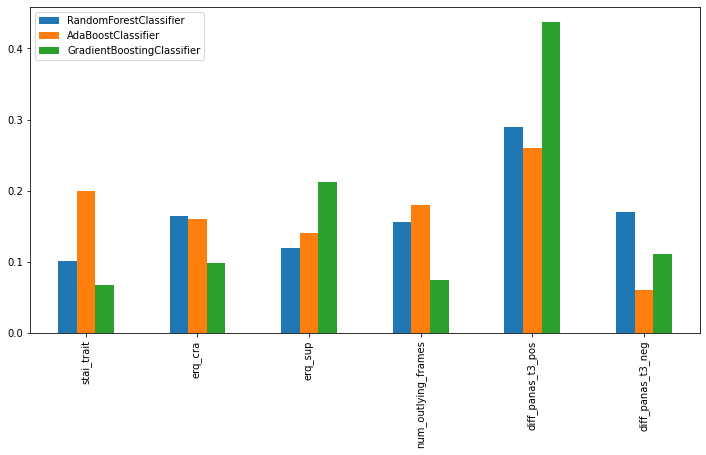

In [278]:
fig,ax = plt.subplots(figsize = (12,6))
feature_importances_df.plot.bar(ax=ax)

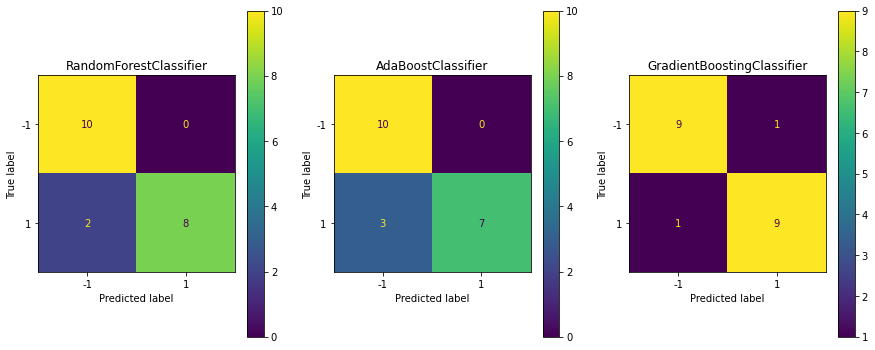

In [279]:
fig,ax = plt.subplots(1,3, figsize = (15,6))
for i,preds in enumerate(ypreds):
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test,preds),
                                display_labels = y_test.unique())

    disp.plot(ax = ax[i])
    ax[i].title.set_text(str(clfs[i])[:-17])
    

In [280]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [5,10,20,30],"max_depth": [3,5,10,15],"max_leaf_nodes": [4,6,8,10]}
]
rndf_clf = RandomForestClassifier()
grid_search = GridSearchCV(rndf_clf,param_grid,cv = 5, return_train_score=True)
grid_search.fit(X_resamp,y_resamp)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [3, 5, 10, 15],
                          'max_leaf_nodes': [4, 6, 8, 10],
                          'n_estimators': [5, 10, 20, 30]}],
             return_train_score=True)

In [281]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_depth': 5, 'max_leaf_nodes': 10, 'n_estimators': 10}
RandomForestClassifier(max_depth=5, max_leaf_nodes=10, n_estimators=10)


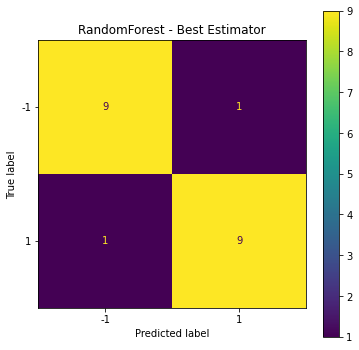

In [293]:
rndf_clf_best = RandomForestClassifier(n_estimators = 10, max_depth = 5, max_leaf_nodes=10).fit(X_resamp,y_resamp)
rndf_best_pred = rndf_clf_best.predict(X_test)
fig,ax = plt.subplots(figsize = (6,6))
disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test,preds),
    display_labels = y_test.unique()
    )
disp.plot(ax=ax)
ax.title.set_text("RandomForest - Best Estimator")

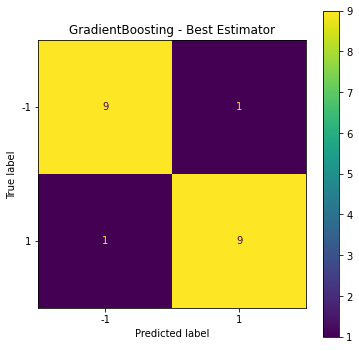

In [316]:
gbt_clf = GradientBoostingClassifier().fit(X_resamp,y_resamp)
gbt_pred = gbt_clf.predict(X_test)
fig,ax = plt.subplots(figsize = (6,6))
disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test,preds),
    display_labels = y_test.unique()
    )
disp.plot(ax=ax)
ax.title.set_text("GradientBoosting - Best Estimator")

In [ ]:
sns.barplot(x = "feature")

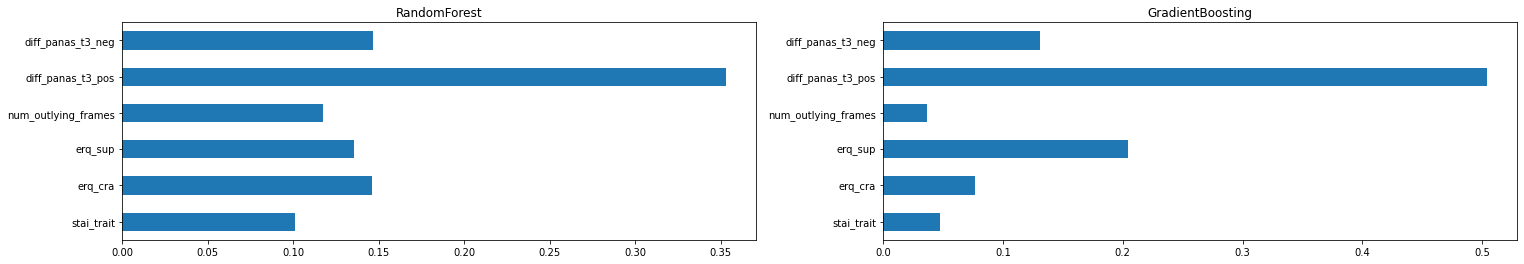

In [331]:
fig,ax = plt.subplots(1,2, figsize = (25,4))
feat_imp_rndf = pd.Series(rndf_clf_best.feature_importances_,index = X_resamp.columns).plot(kind = "barh",ax = ax[0])
feat_imp_gbt = pd.Series(gbt_clf.feature_importances_,index = X_resamp.columns).plot(kind = "barh",ax = ax[1])
ax[0].title.set_text("RandomForest")
ax[1].title.set_text("GradientBoosting")